# Severstal Steel Defect Detection Competition
## Introduction & Dataset Analysis

This notebook provides a comprehensive introduction to the Severstal Steel Defect Detection competition, including dataset exploration, problem understanding, and key insights.


## Table of Contents

1. [Competition Overview](#competition-overview)
2. [Problem Understanding](#problem-understanding)
3. [Dataset Structure](#dataset-structure)
4. [Data Exploration](#data-exploration)
5. [Defect Analysis](#defect-analysis)
6. [Key Insights & Challenges](#key-insights)
7. [Solution Approach](#solution-approach)


## 1. Competition Overview

### Background

The **Severstal Steel Defect Detection** competition is a Kaggle challenge focused on automating quality control in steel manufacturing. The goal is to identify and localize defects in steel surface images using computer vision and deep learning techniques.

### Business Impact

- **Quality Assurance**: Automated defect detection reduces human error and inspection time
- **Cost Efficiency**: Early detection prevents defective products from reaching customers
- **Scalability**: Real-time monitoring of production lines
- **Consistency**: Standardized quality assessment across all products

### Competition Details

- **Platform**: Kaggle
- **Task Type**: Multi-label semantic segmentation
- **Evaluation Metric**: Dice coefficient (F1 score for segmentation)
- **Submission Format**: Run-length encoding (RLE) for each defect class


## 2. Problem Understanding

### Problem Type

This is a **multi-label semantic segmentation** problem:

- **Input**: RGB images of steel surfaces (256×1600 pixels)
- **Output**: Pixel-level masks for 4 different defect types
- **Multi-label**: Each image can contain **zero, one, or multiple** defect classes simultaneously
- **Segmentation**: We need to identify the **exact location** of each defect, not just classify the image

### Defect Classes

The competition involves detecting **4 distinct types of defects**:

1. **Class 1**: Defect type 1 (specific characteristics)
2. **Class 2**: Defect type 2 (specific characteristics)
3. **Class 3**: Defect type 3 (specific characteristics)
4. **Class 4**: Defect type 4 (specific characteristics)

### Evaluation Metric: Dice Coefficient

The Dice coefficient (also known as Sørensen-Dice coefficient) measures the overlap between predicted and ground truth masks:

$$\text{Dice} = \frac{2|X \cap Y|}{|X| + |Y|} = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}$$

Where:
- $X$ = predicted mask
- $Y$ = ground truth mask
- TP = True Positives, FP = False Positives, FN = False Negatives

**Why Dice?**
- Handles class imbalance well (defects are rare)
- Focuses on overlap quality, not just pixel accuracy
- Standard metric for medical and industrial segmentation tasks


## 3. Dataset Structure

Let's start by examining the dataset structure and loading the data.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
DATA_ROOT = "/home/frank/Dropbox/Project/kaggle_severstal/input/"  # Update this path
TRAIN_CSV = os.path.join(DATA_ROOT, "train.csv")
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "train_images")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load training data
train_df = pd.read_csv(TRAIN_CSV)

print(f"Dataset shape: {train_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head(10))
print(f"\nColumn names: {train_df.columns.tolist()}")
print(f"\nData types:")
print(train_df.dtypes)


Dataset shape: (50272, 2)

First few rows:
   ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN
5  00031f466.jpg_2                                                NaN
6  00031f466.jpg_3                                                NaN
7  00031f466.jpg_4                                                NaN
8  000418bfc.jpg_1                                                NaN
9  000418bfc.jpg_2                                                NaN

Column names: ['ImageId_ClassId', 'EncodedPixels']

Data types:
ImageId_ClassId    object
EncodedPixels      object
dtype: object


In [3]:
# Understand the data format
print("Dataset Structure Analysis:")
print("=" * 60)

# Check if ImageId_ClassId format or separate columns
if 'ImageId_ClassId' in train_df.columns:
    print("Format: Combined ImageId_ClassId column")
    # Split into ImageId and ClassId
    train_df['ImageId'], train_df['ClassId'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
    train_df['ClassId'] = train_df['ClassId'].astype(int)
else:
    print("Format: Separate ImageId and ClassId columns")
    train_df['ClassId'] = train_df['ClassId'].astype(int)

print(f"\nTotal rows: {len(train_df)}")
print(f"Unique images: {train_df['ImageId'].nunique()}")
print(f"Unique classes: {sorted(train_df['ClassId'].unique())}")
print(f"\nMissing EncodedPixels (no defect): {train_df['EncodedPixels'].isna().sum()}")


Dataset Structure Analysis:
Format: Combined ImageId_ClassId column

Total rows: 50272
Unique images: 12568
Unique classes: [1, 2, 3, 4]

Missing EncodedPixels (no defect): 43177


### Data Format Explanation

The training data contains:

- **ImageId**: Name of the image file (e.g., `0002cc93b.jpg`)
- **ClassId**: Defect class (1, 2, 3, or 4)
- **EncodedPixels**: Run-length encoding (RLE) of the defect mask, or `NaN` if no defect

**Key Insight**: Each row represents one image-class combination. An image with 2 defects will have 2 rows (one for each class).


## 4. Data Exploration

Let's explore the dataset to understand its characteristics.


In [4]:
# Helper function to decode RLE to mask
def rle2mask(rle_string, shape):
    """
    Convert run-length encoding to binary mask
    
    Args:
        rle_string: Run-length encoded string (e.g., '1 3 10 5')
        shape: (height, width) of the mask
    
    Returns:
        Binary mask as numpy array
    """
    if pd.isna(rle_string) or rle_string == '' or rle_string == ' ':
        return np.zeros(shape, dtype=np.uint8)
    
    rle = np.array([int(x) for x in rle_string.split()])
    starts = rle[0::2] - 1  # Convert to 0-indexed
    lengths = rle[1::2]
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start+length] = 1
    
    return mask.reshape(shape).T  # Transpose to match image orientation

print("RLE decoder function defined!")


RLE decoder function defined!


Defect Class Distribution:

Number of defects per class:
  Class 1: 897 defects
  Class 2: 247 defects
  Class 3: 5,150 defects
  Class 4: 801 defects


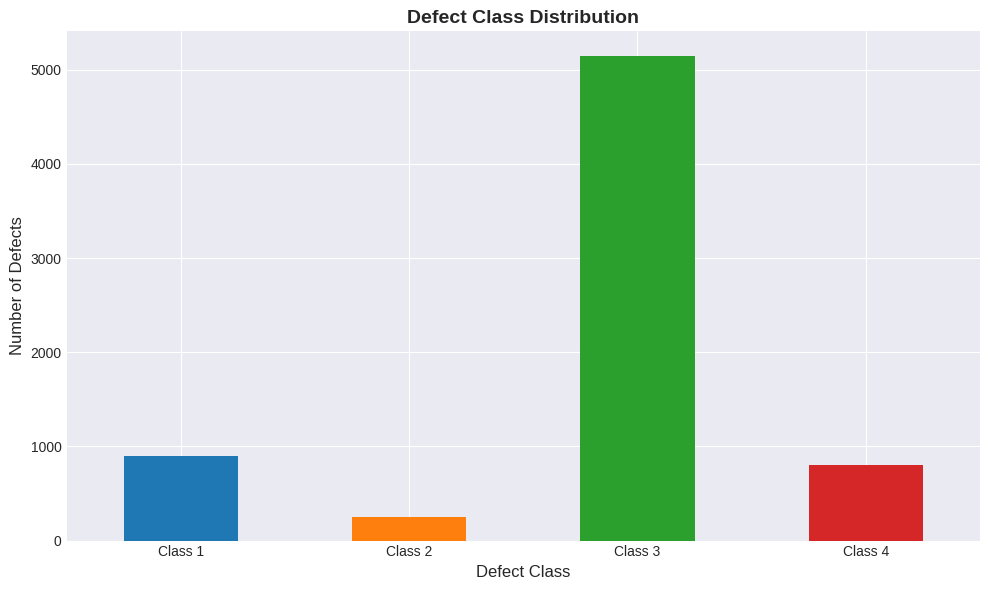

In [5]:
# Analyze defect distribution
print("Defect Class Distribution:")
print("=" * 60)

# Count defects per class
class_counts = train_df.groupby('ClassId')['EncodedPixels'].apply(
    lambda x: x.notna().sum()
).sort_index()

print("\nNumber of defects per class:")
for class_id, count in class_counts.items():
    print(f"  Class {class_id}: {count:,} defects")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
class_counts.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_xlabel('Defect Class', fontsize=12)
ax.set_ylabel('Number of Defects', fontsize=12)
ax.set_title('Defect Class Distribution', fontsize=14, fontweight='bold')
ax.set_xticklabels([f'Class {i}' for i in class_counts.index], rotation=0)
plt.tight_layout()
plt.show()


Defects per Image Analysis:

Number of images with N defects:
  0 defect(s): 5,902 images (47.0%)
  1 defect(s): 6,239 images (49.6%)
  2 defect(s): 425 images (3.4%)
  3 defect(s): 2 images (0.0%)


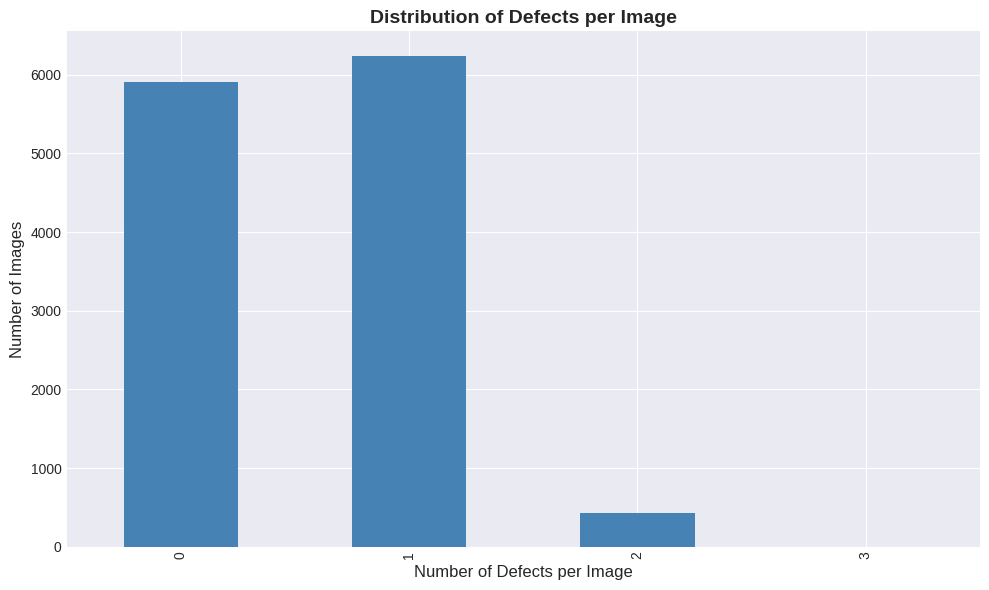

In [6]:
# Analyze images: how many defects per image?
print("Defects per Image Analysis:")
print("=" * 60)

# Count defects per image
defects_per_image = train_df.groupby('ImageId')['EncodedPixels'].apply(
    lambda x: x.notna().sum()
).reset_index(name='num_defects')

defect_counts = defects_per_image['num_defects'].value_counts().sort_index()

print("\nNumber of images with N defects:")
for num_defects, count in defect_counts.items():
    percentage = (count / len(defects_per_image)) * 100
    print(f"  {num_defects} defect(s): {count:,} images ({percentage:.1f}%)")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
defect_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Number of Defects per Image', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Distribution of Defects per Image', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [7]:
# Check for images with multiple defect classes
print("Multi-Class Defect Analysis:")
print("=" * 60)

# Get images with defects
images_with_defects = train_df[train_df['EncodedPixels'].notna()]['ImageId'].unique()

# For each image, count unique classes with defects
multi_class_images = []
for img_id in images_with_defects:
    classes = train_df[(train_df['ImageId'] == img_id) & 
                       (train_df['EncodedPixels'].notna())]['ClassId'].unique()
    if len(classes) > 1:
        multi_class_images.append((img_id, len(classes), sorted(classes)))

print(f"\nTotal images with defects: {len(images_with_defects):,}")
print(f"Images with multiple defect classes: {len(multi_class_images):,}")
print(f"Percentage: {len(multi_class_images)/len(images_with_defects)*100:.2f}%")

if len(multi_class_images) > 0:
    print("\nExample images with multiple classes:")
    for img_id, num_classes, classes in multi_class_images[:5]:
        print(f"  {img_id}: {num_classes} classes - {classes}")


Multi-Class Defect Analysis:

Total images with defects: 6,666
Images with multiple defect classes: 427
Percentage: 6.41%

Example images with multiple classes:
  0025bde0c.jpg: 2 classes - [3, 4]
  002fc4e19.jpg: 2 classes - [1, 2]
  008ef3d74.jpg: 2 classes - [1, 2]
  00ac8372f.jpg: 2 classes - [1, 2]
  00c88fed0.jpg: 2 classes - [1, 2]


## 5. Defect Analysis

Let's visualize some sample images and their defect masks to understand the problem better.


In [8]:
# Helper function to visualize images with defects
def visualize_defects(image_id, train_df, images_dir, max_classes=4):
    """
    Visualize an image with all its defect masks overlaid
    """
    # Load image
    img_path = os.path.join(images_dir, image_id)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get all defects for this image
    image_rows = train_df[train_df['ImageId'] == image_id]
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image\n{image_id}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Individual class masks
    combined_mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # R, G, B, Y
    
    for idx, (_, row) in enumerate(image_rows.iterrows()):
        class_id = row['ClassId']
        rle = row['EncodedPixels']
        
        if pd.notna(rle) and rle != '' and rle != ' ':
            mask = rle2mask(rle, (256, 1600))
            
            # Show individual mask
            axes[class_id].imshow(mask, cmap='gray')
            axes[class_id].set_title(f'Class {class_id} Mask\nArea: {mask.sum()} pixels', 
                                    fontsize=12, fontweight='bold')
            axes[class_id].axis('off')
            
            # Add to combined mask
            color = colors[class_id - 1]
            combined_mask[mask > 0] = color
        else:
            # No defect for this class
            axes[class_id].text(0.5, 0.5, 'No Defect', 
                              ha='center', va='center', fontsize=14)
            axes[class_id].set_title(f'Class {class_id} - No Defect', fontsize=12)
            axes[class_id].axis('off')
    
    # Combined overlay
    overlay = cv2.addWeighted(img, 0.7, combined_mask, 0.3, 0)
    axes[4].imshow(overlay)
    axes[4].set_title('All Defects Overlay\nRed=Class1, Green=Class2, Blue=Class3, Yellow=Class4', 
                     fontsize=12, fontweight='bold')
    axes[4].axis('off')
    
    # Hide unused subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization function defined!")


Visualization function defined!


Defect Size Analysis:

Defect Size Statistics (pixels):

Class 1:
  Count: 897
  Mean: 4361.3 pixels
  Median: 3326.0 pixels
  Min: 163 pixels
  Max: 31,303 pixels
  Std: 3589.1 pixels

Class 2:
  Count: 247
  Mean: 3378.4 pixels
  Median: 2944.0 pixels
  Min: 316 pixels
  Max: 14,023 pixels
  Std: 2045.2 pixels

Class 3:
  Count: 5,150
  Mean: 25496.5 pixels
  Median: 11953.5 pixels
  Min: 115 pixels
  Max: 368,240 pixels
  Std: 37941.6 pixels

Class 4:
  Count: 801
  Mean: 34374.0 pixels
  Median: 25357.0 pixels
  Min: 491 pixels
  Max: 192,780 pixels
  Std: 29571.8 pixels


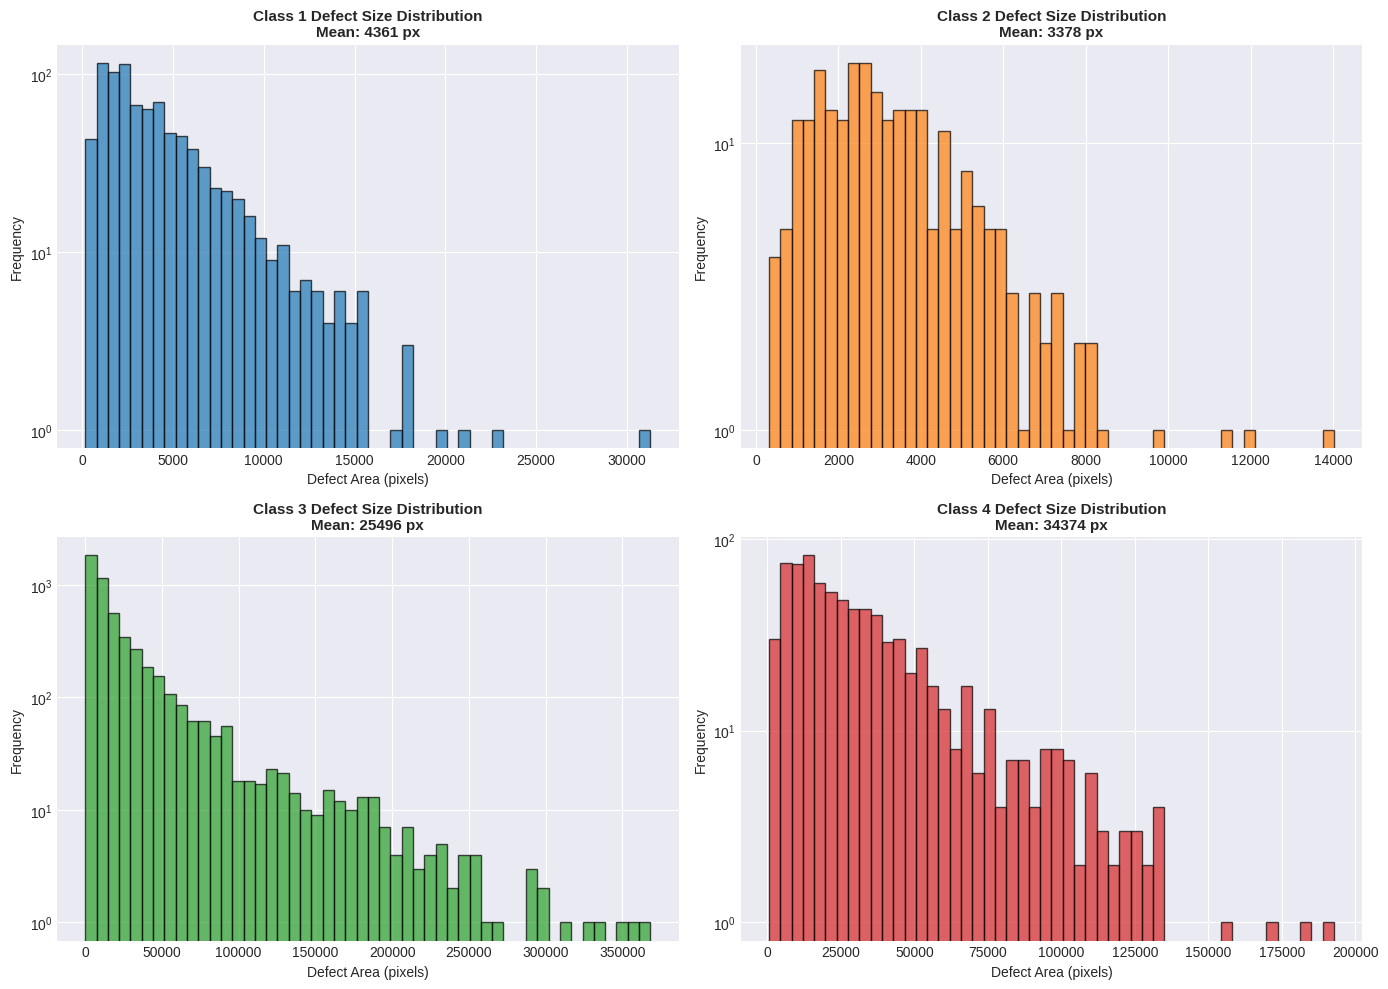

In [9]:
# Analyze defect sizes (area in pixels)
print("Defect Size Analysis:")
print("=" * 60)

defect_sizes = {i: [] for i in range(1, 5)}

for _, row in train_df[train_df['EncodedPixels'].notna()].iterrows():
    class_id = row['ClassId']
    rle = row['EncodedPixels']
    
    if pd.notna(rle) and rle != '' and rle != ' ':
        mask = rle2mask(rle, (256, 1600))
        area = mask.sum()
        defect_sizes[class_id].append(area)

# Statistics per class
print("\nDefect Size Statistics (pixels):")
for class_id in range(1, 5):
    sizes = defect_sizes[class_id]
    if len(sizes) > 0:
        print(f"\nClass {class_id}:")
        print(f"  Count: {len(sizes):,}")
        print(f"  Mean: {np.mean(sizes):.1f} pixels")
        print(f"  Median: {np.median(sizes):.1f} pixels")
        print(f"  Min: {np.min(sizes):,} pixels")
        print(f"  Max: {np.max(sizes):,} pixels")
        print(f"  Std: {np.std(sizes):.1f} pixels")

# Visualize size distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for class_id in range(1, 5):
    sizes = defect_sizes[class_id]
    if len(sizes) > 0:
        axes[class_id-1].hist(sizes, bins=50, color=plt.cm.tab10(class_id-1), alpha=0.7, edgecolor='black')
        axes[class_id-1].set_xlabel('Defect Area (pixels)', fontsize=10)
        axes[class_id-1].set_ylabel('Frequency', fontsize=10)
        axes[class_id-1].set_title(f'Class {class_id} Defect Size Distribution\nMean: {np.mean(sizes):.0f} px', 
                                 fontsize=11, fontweight='bold')
        axes[class_id-1].set_yscale('log')

plt.tight_layout()
plt.show()


## 6. Key Insights & Challenges

Based on the data exploration, here are the key insights and challenges:

### Insights

1. **Class Imbalance**: Different defect classes have different frequencies, requiring careful handling in loss functions

2. **Multi-label Nature**: Images can have multiple defect types simultaneously, requiring multi-label segmentation

3. **Variable Defect Sizes**: Defects range from small to very large, requiring models that can detect at multiple scales

4. **Sparse Defects**: Many images have no defects, creating a class imbalance between defect and non-defect pixels

5. **High Resolution**: Images are 256×1600 pixels, requiring efficient memory management during training

### Challenges

1. **Memory Constraints**: Full-resolution images require significant GPU memory
   - **Solution**: Use image cropping or pre-cropping strategies

2. **Class Imbalance**: Rare defects are harder to detect
   - **Solution**: Use weighted loss functions (e.g., BCE with positive weights, Dice loss)

3. **Multi-scale Detection**: Defects vary greatly in size
   - **Solution**: Use architectures with multi-scale features (UNet, FPN, DeepLabV3)

4. **Precision Requirements**: Industrial quality control requires high precision
   - **Solution**: Post-processing with thresholding and minimum area filtering

5. **Evaluation Metric**: Dice coefficient requires careful threshold tuning
   - **Solution**: Systematic hyperparameter tuning on validation set


## 7. Solution Approach

### Architecture Selection

**UNet** with encoder backbones (EfficientNet, ResNet) is chosen because:

- ✅ Proven performance in medical/industrial segmentation
- ✅ Skip connections preserve fine-grained details
- ✅ Encoder-decoder structure handles multi-scale features
- ✅ Efficient training and inference

### Training Strategy

1. **5-Fold Stratified Cross-Validation**: Ensures robust evaluation and prevents overfitting

2. **Image Cropping**: Convert 256×1600 images to 256×512 crops
   - Increases training samples by 6x
   - Reduces memory requirements
   - Improves model generalization

3. **Loss Function**: Combined BCE + Dice with positive weighting
   - Handles class imbalance
   - Optimizes directly for Dice metric

4. **Data Augmentation**: Horizontal/vertical flips, brightness/contrast adjustments
   - Increases data diversity
   - Improves model robustness

5. **Post-Processing**: Threshold tuning and minimum area filtering
   - Reduces false positives
   - Optimizes submission quality

### Model Ensemble

- Train multiple models with different encoders (EfficientNet-B3, ResNet34, SE-ResNeXt50)
- Average predictions across models and folds
- Improves robustness and generalization


## Summary

This notebook has provided a comprehensive introduction to the Severstal Steel Defect Detection competition:

1. ✅ **Competition Overview**: Understanding the business context and problem type
2. ✅ **Dataset Analysis**: Exploring data structure, defect distribution, and characteristics
3. ✅ **Visualization**: Examining sample images and defect patterns
4. ✅ **Key Insights**: Identifying challenges and appropriate solutions
5. ✅ **Solution Approach**: Outlining the technical strategy

### Next Steps

For a complete solution, the following components would be implemented:

- Model training pipeline with cross-validation
- Inference pipeline with ensemble predictions
- Post-processing parameter tuning
- Submission generation

---

**Thank you for reviewing this analysis!**

For questions or further discussion, please feel free to reach out.
